In [135]:
import fiona
import numpy as np
from pathlib import Path
import os

import rasterio as rio
from rasterio import windows
from rasterio import features
import rasterio.plot as rioplot
from rasterio.warp import transform_bounds

from itertools import product
from rtree import index

from shapely.geometry import mapping, LineString, shape
import json

import matplotlib.pyplot as plt
%matplotlib inline 

In [136]:
from functools import partial
import pyproj 
from shapely.ops import transform

# This note book implements the following algoritm
-  Build a Rtree (Spatial) index for all LineStrings in labeled road data ( Bounding box being the index key. For line : left=bottom, top=right )
- Split Satellite Tif images into smaller 1500*1500 image tiles - ( Rasterio Windowed reading  )
-  For each Tile:
    -  Look up lines intersecting with the tile bounding box from the Rtree Index
    -  Create Geojson/Geometry from intersecting lines (Map)
    -  Use rasterise to create a tiff file from the Geometry
    -  Write Tile and corresponding Map to the file

Input: 
- data folder in the project root (sibling of src folder)
- data/raw/images holds raw satellite images (raster) from planet.com
- data/raw/labesl holds road labels in geojson format (as if now, need to be extended to handle kmz, kml files)*

Output:

- data/train/sat will have window_size * window_size (1500 * 1500) tif image tiles with information. All Blank tiles are being discared
- data/train/map will have window_size * window_size (1500 * 1500) tif map tiles that can be used as target map for a NN


In [137]:
DST_CRS = 'EPSG:4326'

RAW_IMAGES = '../data/raw/images'
RAW_LABELS = '../data/raw/labels'

TRAINING_DIR = '../data/train'
TRAINING_SAT_DIR = '{}/sat'.format(TRAINING_DIR)
TRAINING_MAP_DIR = '{}/map'.format(TRAINING_DIR)

In [138]:
window_size = 1500
output_tile_filename = '{}/tile_{}-{}.tif'
output_map_filename = '{}/tile_{}-{}.tif'

*Create output directories in case it doesn't exist. The contents of data folder has been gitignored intentionally as they'll contain huge image files.*

In [139]:
Path("../data").mkdir(exist_ok=True)
Path(RAW_IMAGES).mkdir(exist_ok=True)
Path(RAW_LABELS).mkdir(exist_ok=True)

Path(TRAINING_DIR).mkdir(exist_ok=True)
Path(TRAINING_SAT_DIR).mkdir(exist_ok=True)
Path(TRAINING_MAP_DIR).mkdir(exist_ok=True)

# create_spatial_index:

*Method to create spatial index for lines.*

*The key of index is bounding box for the line. note that for a line bounding box will have left=bottom, top=right.*

*The payload in the index is the LineString object as if now. May have to change this to another object (feature??) that retains properties (label for paved/unpaved roads)*


In [140]:

def create_spatial_index():
    idx = index.Index()
    with fiona.open("{}/walker_3093.geojson".format(RAW_LABELS), "r") as geojson:
        lines = [LineString(feature["geometry"]["coordinates"]) for feature in geojson]
        count = -1
        for line in lines:
            count +=1
            idx.insert(count, line.bounds, obj=line)
    return idx    

In [141]:
def transform_bnds(src_crs, dst_crs,src_bounds):
    return transform_bounds(src_crs,dst_crs,src_bounds[0], src_bounds[1], src_bounds[2], src_bounds[3] )

In [142]:
p1=pyproj.Proj(init=DST_CRS) 
p2=pyproj.Proj(init='EPSG:32750') #the is the crs of the source raster file
project = partial(pyproj.transform, p1, p2)

# Write Map
- for a given tile, find the lines intersecting the tile from Rtree index
- use rasterize to convert the geometry (lines) to a tiff raster image
- project is used to project line geometry to crs of satellite image (EPSG:32750) so that we can the same transform we used to create satellite image tile to create map. This is cruitial to make the map and satellite image tile align.

In [143]:
def write_map(src, window, meta, ax_map):
    outpath = output_map_filename.format(TRAINING_MAP_DIR,int(window.col_off),int(window.row_off))
    dst_bounds = transform_bnds(src.crs, DST_CRS, src.window_bounds(window))

    intersecting_road_items = idx.intersection(dst_bounds,objects=True)
    lines = [r.object for r in intersecting_road_items]

    m2 = meta.copy()
    m2['count']=1
    nodata=255
    with rio.open(outpath, 'w', **m2) as outds:
        if len(lines) > 0:
            g2 = [ transform(project, line) for line in lines]
            burned = features.rasterize(g2,
                                        fill=nodata,
                                        out_shape=(window_size, window_size),
                                        all_touched=True,
                                        transform=meta['transform'])
            masked = np.ma.masked_where(burned == nodata, burned)
            ax_map.imshow(masked, cmap="flag")
            outds.write(burned, indexes=1)


# Write Tile
- read window from source satellite image
- write tile image to disk

In [144]:
def write_tile(src, window, meta, ax_tile):
    outpath = output_tile_filename.format(TRAINING_SAT_DIR,int(window.col_off),int(window.row_off))
    with rio.open(outpath, 'w', **meta) as outds:
        tile = src.read(window=window)
        rioplot.show(tile, ax=ax_tile, cmap='gray')
        outds.write(tile)

In [145]:
def window_is_empty(raster, window):
    return not np.any(raster.read(window=window))

# Make tiles
*Iterate thorough windows of size window_size and write_tile and write_map for the same.*
*Discard empty images*

In [146]:
def make_tiles(file):
    with rio.open(file) as inds:
          tile_width, tile_height = window_size, window_size
          meta = inds.meta.copy()
          far window, transform in get_tiles(inds):
            if not window_is_empty(inds, window):
                meta['transform'] = transform
                meta['width'], meta['height'] = window.width, window.height
                fig, ax = plt.subplots(figsize=(10,10))
                write_tile(inds, window, meta, ax)
                write_map(inds, window, meta, ax)
                plt.show()

*For a given raster image ds, get_tiles method uses rasterio.Window to return an iterator of windows and it transform* 

In [147]:
def get_tiles(ds, width=window_size, height=window_size):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

- Iterate through all satellite images in /data/raw/images
- Breaking after n >=1 for testing purp


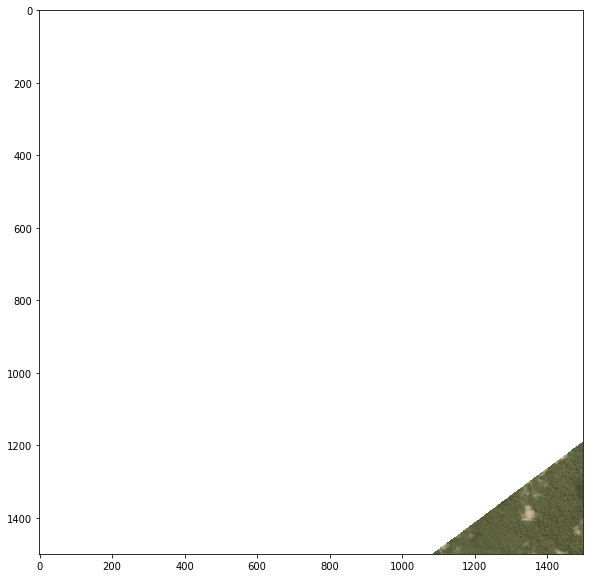

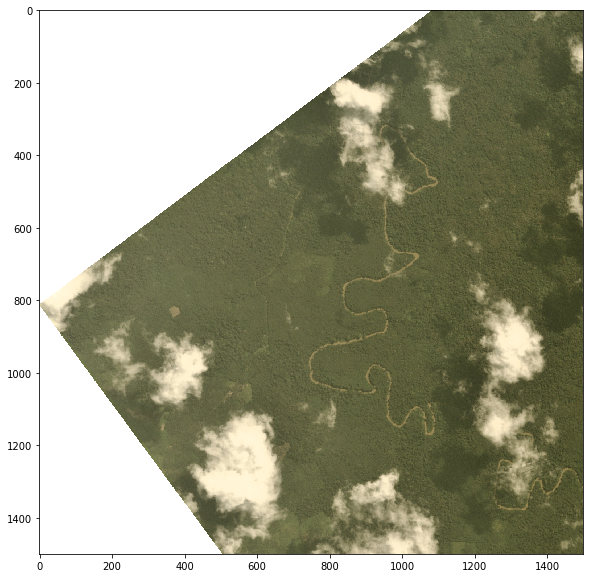

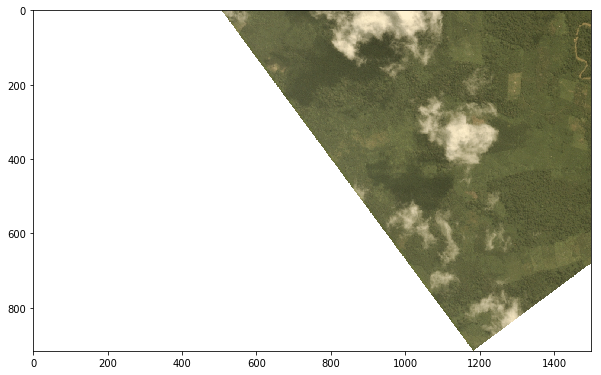

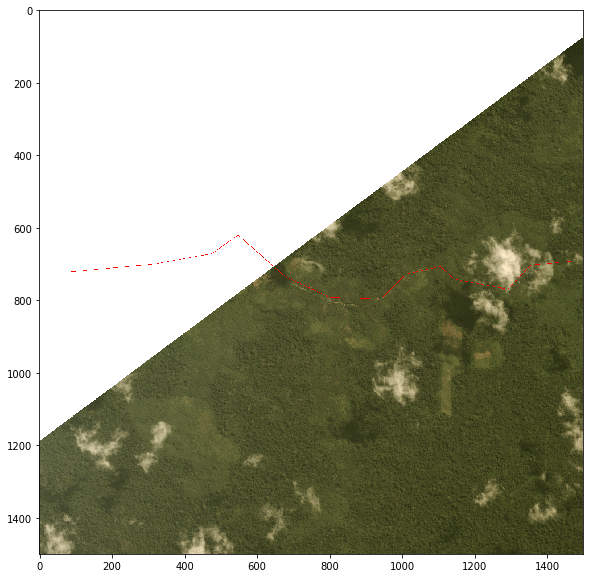

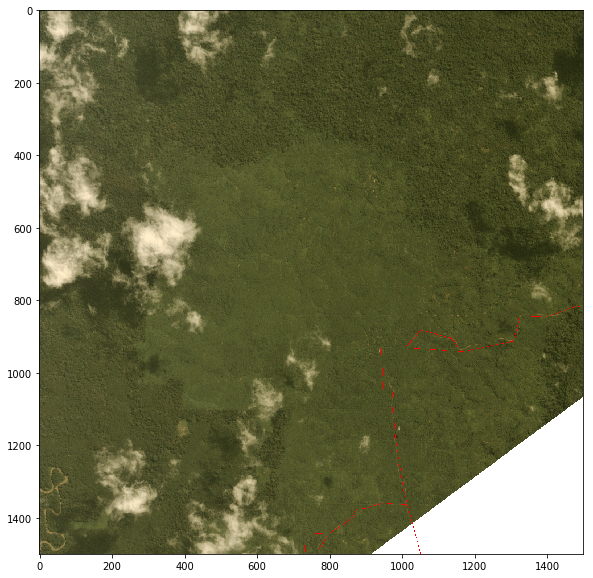

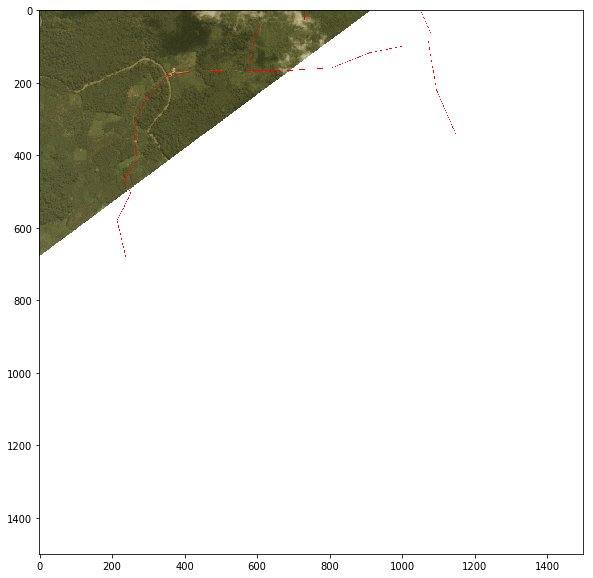

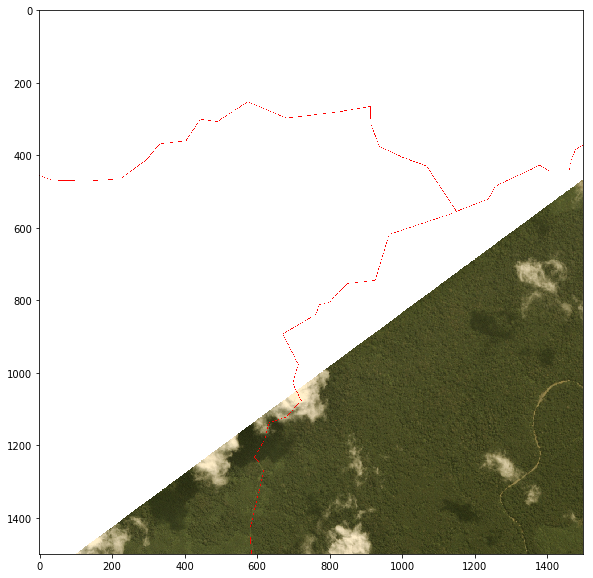

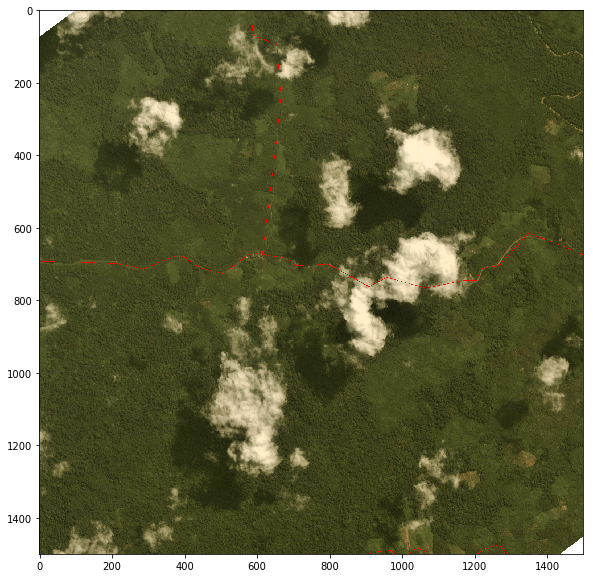

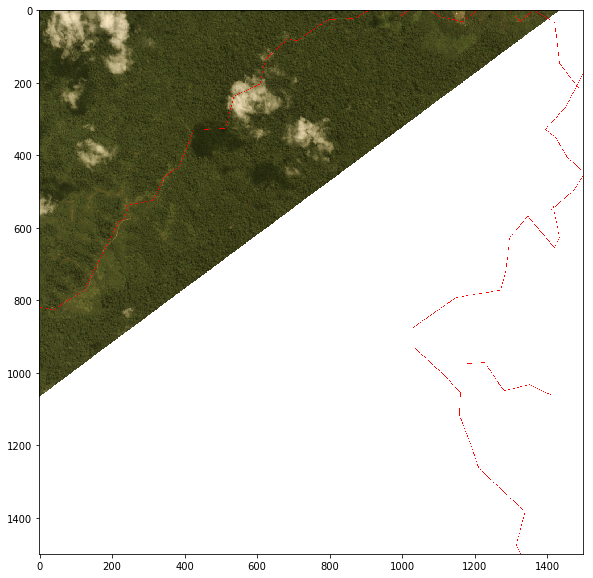

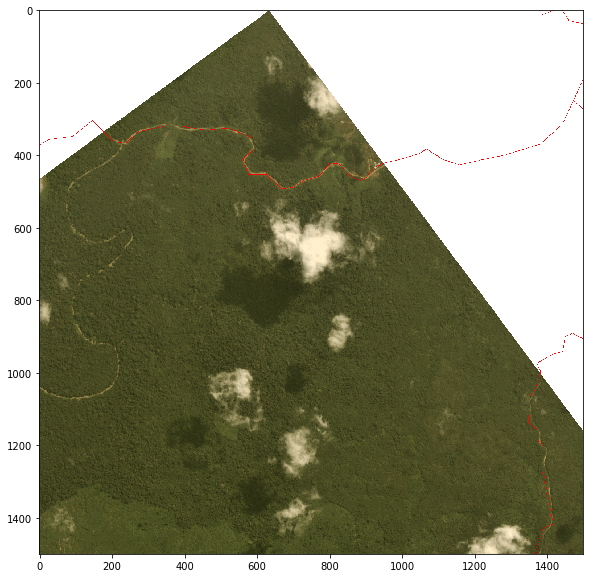

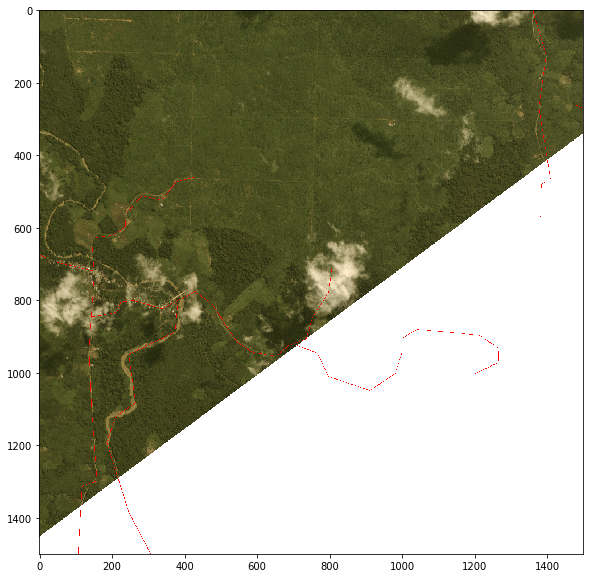

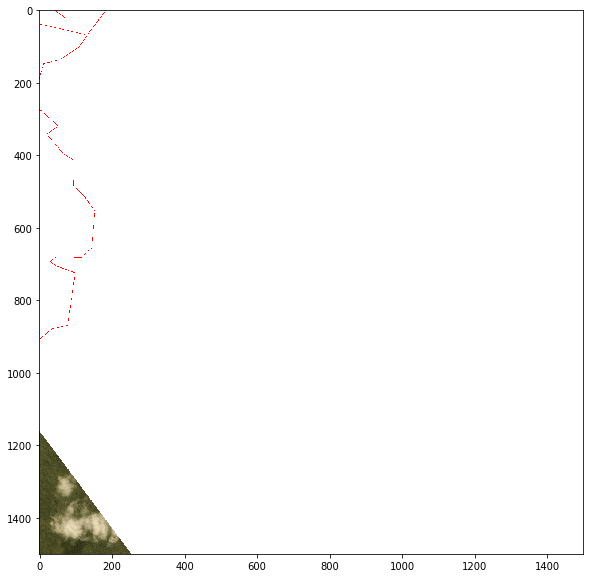

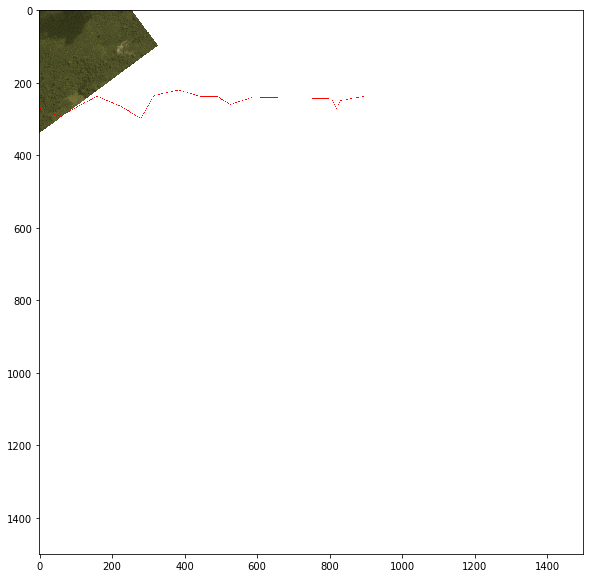

In [148]:
n = 0
idx=create_spatial_index()
for file in Path(RAW_IMAGES).iterdir():
    if file.name.endswith(('.tif', '.tiff')):
        make_tiles(file)
        n=n+1
        if n >= 1:
            break